Source: https://www.kaggle.com/kyanyoga/sample-sales-data

In [1]:
import pandas as pd
import numpy as np
import json

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from IPython.core.display import HTML, display

In [2]:
HTML("""<style>.container { width:100% !important; } div.output_area {overflow-y: scroll;} div.output_area img {max-width: unset;} </style>""") 

In [3]:
df = pd.read_csv('sales_data_sample.csv', encoding = "ISO-8859-1")
alt_df = df.copy()

alt_df['CONTACTID'] = (alt_df.CONTACTFIRSTNAME + ' ' + alt_df.CONTACTLASTNAME).astype('category').cat.codes
alt_df['TIME'] = alt_df.MONTH_ID + (alt_df.YEAR_ID-alt_df['YEAR_ID'].min()) * 12
alt_df['MSRPDIFF'] = alt_df.SALES - alt_df.QUANTITYORDERED * alt_df.MSRP

alt_df = alt_df[['ORDERNUMBER', 'CONTACTID', 'QUANTITYORDERED', 'PRICEEACH',
       'SALES', 'STATUS', 'QTR_ID', 'TIME', 'PRODUCTLINE', 'MSRP', 'MSRPDIFF',
       'PRODUCTCODE', 'CUSTOMERNAME', 'CITY','COUNTRY', 'DEALSIZE']] #TERRITORY
alt_df = alt_df.dropna()
alt_df.head()

,ORDERNUMBER,CONTACTID,QUANTITYORDERED,PRICEEACH,SALES,STATUS,QTR_ID,TIME,PRODUCTLINE,MSRP,MSRPDIFF,PRODUCTCODE,CUSTOMERNAME,CITY,COUNTRY,DEALSIZE
0,10107,42,30,95.70,2871.00,Shipped,1,2,Motorcycles,95,21.00,S10_1678,Land of Toys Inc.,NYC,USA,Small
1,10121,67,34,81.35,2765.90,Shipped,2,5,Motorcycles,95,-464.10,S10_1678,Reims Collectables,Reims,France,Small
2,10134,11,41,94.74,3884.34,Shipped,3,7,Motorcycles,95,-10.66,S10_1678,Lyon Souveniers,Paris,France,Medium
3,10145,36,45,83.26,3746.70,Shipped,3,8,Motorcycles,95,-528.30,S10_1678,Toys4GrownUps.com,Pasadena,USA,Medium
4,10159,33,49,100.00,5205.27,Shipped,4,10,Motorcycles,95,550.27,S10_1678,Corporate Gift Ideas Co.,San Francisco,USA,Medium


#### Analyzing continuous values

/Users/Radomir/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



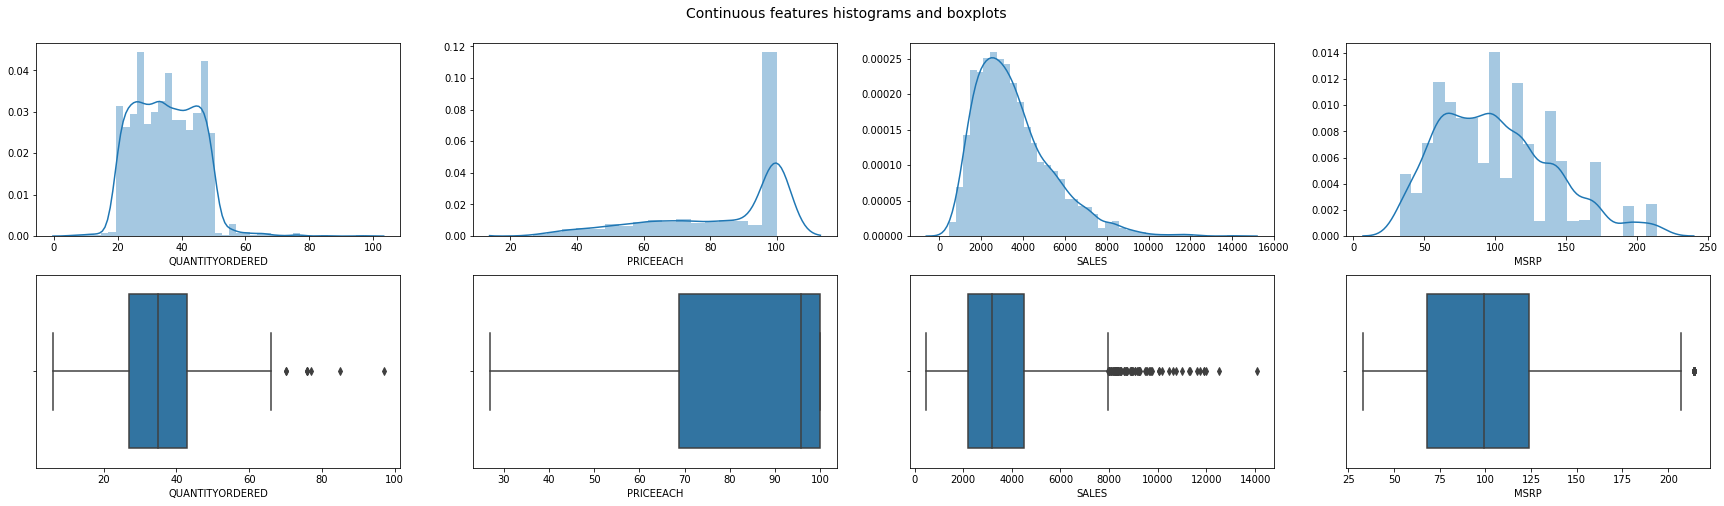

In [4]:
continuous_columns = ['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'MSRP']
fig, axs = plt.subplots(2, len(continuous_columns), figsize=(30, 5))
plt.subplots_adjust(bottom=-0.3)
plt.suptitle("Continuous features histograms and boxplots", fontsize=14)

for i, column in enumerate(continuous_columns):
    _ = sns.distplot(alt_df[column], ax=axs[0,i])
    _ = sns.boxplot(alt_df[column], ax=axs[1,i])

#### Analyzing categorical values

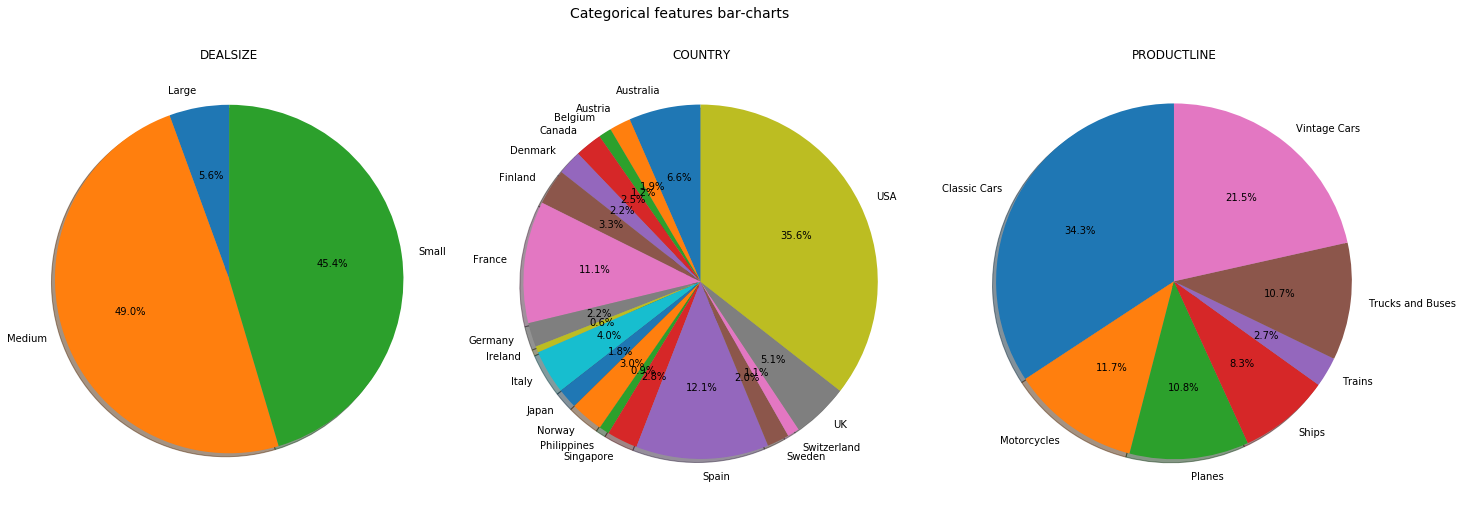

In [5]:
categorical_columns = ['DEALSIZE', 'COUNTRY', 'PRODUCTLINE']
fig, axs = plt.subplots(1, len(categorical_columns), figsize=(24, 8))
plt.suptitle("Categorical features bar-charts", fontsize=14)

for i, column in enumerate(categorical_columns):
    column_dict = alt_df.groupby([column], as_index=False).size().to_dict()
    axs[i].pie(column_dict.values(), labels=column_dict.keys(), autopct='%1.1f%%',
            shadow=True, startangle=90)
    axs[i].set_title(column)
    axs[i].axis('equal')  
    
plt.show()

## Assessing correlation between variables

In [21]:
alt_df[['COUNTRY', 'SALES']].groupby(['COUNTRY']).mean().sort_values('SALES', ascending=False)

,SALES
COUNTRY,
Denmark,3899.002381
Switzerland,3797.211613
Sweden,3684.459825
Austria,3673.864182
Singapore,3651.752025
Japan,3618.611731
Norway,3617.220000
Philippines,3615.989615
USA,3613.528715


In [22]:
pd.crosstab(alt_df['PRODUCTLINE'], alt_df['COUNTRY'])

COUNTRY,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
PRODUCTLINE,,,,,,,,,,,,,,,,,,,
Classic Cars,53,25,4,14,34,38,98,36,6,28,8,35,13,32,120,17,31,46,329
Motorcycles,26,5,0,1,0,13,68,3,2,2,9,14,7,1,19,3,0,9,149
Planes,25,6,1,10,2,12,32,8,4,31,16,11,5,0,30,3,0,15,95
Ships,2,4,11,14,14,9,21,2,0,6,5,0,0,4,39,10,0,23,70
Trains,1,0,3,0,4,2,7,2,2,3,2,2,0,5,14,1,0,4,25
Trucks and Buses,20,5,0,16,2,11,30,2,1,2,3,9,0,23,46,11,0,8,112
Vintage Cars,58,10,14,15,7,7,58,9,1,41,9,14,1,14,74,12,0,39,224


In [23]:
alt_df.groupby(['STATUS']).size().sort_values(ascending=False).to_frame(name='size')

,size
STATUS,
Shipped,2617
Cancelled,60
Resolved,47
On Hold,44
In Process,41
Disputed,14


In [24]:
print(alt_df.groupby(['STATUS']).size().sort_values(ascending=False).to_frame(name='size').transpose())
alt_df[alt_df['STATUS']== 'Disputed']

STATUS  Shipped  Cancelled  Resolved  On Hold  In Process  Disputed
size       2617         60        47       44          41        14


,ORDERNUMBER,CONTACTID,QUANTITYORDERED,PRICEEACH,SALES,STATUS,QTR_ID,TIME,PRODUCTLINE,MSRP,MSRPDIFF,PRODUCTCODE,CUSTOMERNAME,CITY,COUNTRY,DEALSIZE,RECENCY
25,10417,14,66,100.00,7516.08,Disputed,2,29,Motorcycles,95,1246.08,S10_1678,Euro Shopping Channel,Madrid,Spain,Large,18
79,10417,14,45,100.00,5887.35,Disputed,2,29,Motorcycles,118,577.35,S10_2016,Euro Shopping Channel,Madrid,Spain,Medium,18
105,10417,14,56,100.00,9218.16,Disputed,2,29,Motorcycles,193,-1589.84,S10_4698,Euro Shopping Channel,Madrid,Spain,Large,18
265,10417,14,21,100.00,3447.78,Disputed,2,29,Motorcycles,150,297.78,S12_2823,Euro Shopping Channel,Madrid,Spain,Medium,18
473,10406,39,61,100.00,8374.69,Disputed,2,28,Classic Cars,141,-226.31,S18_1129,Danish Wholesale Imports,Kobenhavn,Denmark,Large,46
651,10406,39,48,100.00,7169.28,Disputed,2,28,Classic Cars,142,353.28,S18_1984,Danish Wholesale Imports,Kobenhavn,Denmark,Large,46
829,10417,14,36,61.18,2202.48,Disputed,2,29,Motorcycles,60,42.48,S18_2625,Euro Shopping Channel,Madrid,Spain,Small,18
1188,10406,39,65,100.00,10468.90,Disputed,2,28,Classic Cars,141,1303.90,S18_3685,Danish Wholesale Imports,Kobenhavn,Denmark,Large,46
1240,10415,73,51,100.00,6209.25,Disputed,2,29,Vintage Cars,105,854.25,S18_3856,"Australian Collectables, Ltd",Glen Waverly,Australia,Medium,22
1491,10417,14,35,100.00,3550.05,Disputed,2,29,Motorcycles,112,-369.95,S24_1578,Euro Shopping Channel,Madrid,Spain,Medium,18


In [25]:
msrpdiff_df = alt_df.groupby('CUSTOMERNAME').agg({'MSRPDIFF': np.mean}).sort_values(by = 'MSRPDIFF', ascending=False)
z_scores_msrpdiff = ((msrpdiff_df['MSRPDIFF'] - msrpdiff_df['MSRPDIFF'].mean())/msrpdiff_df['MSRPDIFF'].std(ddof=0)).values
msrpdiff_df[abs(z_scores_msrpdiff)>2].transpose()

CUSTOMERNAME,Vitachrome Inc.,Lyon Souveniers,Mini Auto Werke,Signal Gift Stores,Marseille Mini Autos,Online Mini Collectables
MSRPDIFF,239.0904,235.767,-208.34,-214.169655,-223.7144,-224.602667


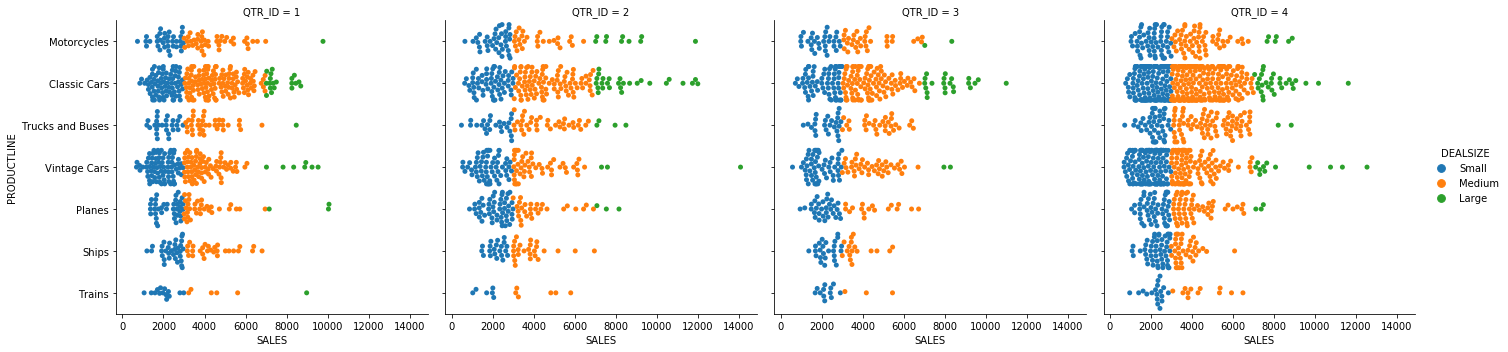

In [26]:
sns.catplot(y="PRODUCTLINE", x="SALES", hue="DEALSIZE", col="QTR_ID", kind="swarm", data=alt_df)

In [27]:
alt_df.groupby('CUSTOMERNAME').filter(lambda g:len(g)>40).groupby('CUSTOMERNAME').size().sort_values(ascending=False)

CUSTOMERNAME
Euro Shopping Channel           259
Mini Gifts Distributors Ltd.    180
Australian Collectors, Co.       55
La Rochelle Gifts                53
AV Stores, Co.                   51
Land of Toys Inc.                49
Rovelli Gifts                    48
Muscle Machine Inc               48
Souveniers And Things Co.        46
Anna's Decorations, Ltd          46
Dragon Souveniers, Ltd.          43
Saveley & Henriot, Co.           41
Reims Collectables               41
Corporate Gift Ideas Co.         41
dtype: int64

#### Simple clustering

/Users/Radomir/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.

/Users/Radomir/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype int64, float64 were all converted to float64 by StandardScaler.



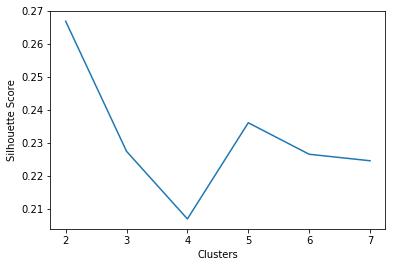

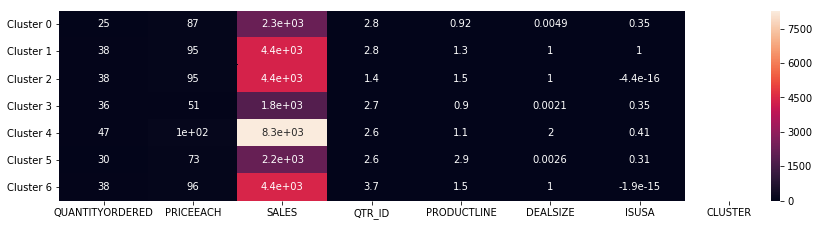

In [28]:
cluster_df = alt_df[['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'QTR_ID', 'PRODUCTLINE', 'COUNTRY', 'DEALSIZE']].copy()
deal_size_dict = {"Small":0, "Medium":1, "Large":2}
productline_dict = {"Motorcycles":0, "Classic Cars":1, "Vintage Cars":1, "Trucks and Buses":2, "Planes":3, "Ships":3, "Trains":3}

cluster_df['ISUSA'] = cluster_df['COUNTRY'].map(lambda x: 1 if x=="USA" else 0).astype(int)
cluster_df = cluster_df.drop(columns=['COUNTRY'])
cluster_df['DEALSIZE'] = cluster_df['DEALSIZE'].map(deal_size_dict).astype(int)
cluster_df['PRODUCTLINE'] = cluster_df['PRODUCTLINE'].map(productline_dict).astype(int)

scaler = StandardScaler()
scaled_cluster_df = scaler.fit_transform(cluster_df)

cluster_nums = [2,3,4,5,6,7]
scores = []
for cluster_num in cluster_nums:
    kmeans = KMeans(cluster_num) 
    kmeans.fit(scaled_cluster_df)
    clusters = kmeans.predict(scaled_cluster_df)
    silhouette = silhouette_score(scaled_cluster_df, clusters) 
    scores.append(silhouette)
    
cluster_df['CLUSTER'] = clusters
    
plt.ylabel('Silhouette Score') 
plt.xlabel('Clusters') 
sns.lineplot(x=cluster_nums,y=scores)

plt.figure(figsize=(15,3.5)) 
sns.heatmap(scaler.inverse_transform(kmeans.cluster_centers_)[:,0:7],
                annot=True, yticklabels=[f'Cluster {i}' for i in range(0,7)],xticklabels=cluster_df.columns.values)

In [29]:
cluster_df[cluster_df['CLUSTER']==5].head()

,QUANTITYORDERED,PRICEEACH,SALES,QTR_ID,PRODUCTLINE,DEALSIZE,ISUSA,CLUSTER
237,39,63.20,2464.80,1,2,0,0,5
386,26,58.38,1517.88,4,2,0,1,5
391,32,66.58,2130.56,1,2,0,1,5
445,29,85.10,2467.90,1,2,0,0,5
554,21,100.00,2781.66,2,3,0,1,5


#### RFM clustering

In [30]:
rfm_df = alt_df.copy()

In [31]:
#FREQUENCY 
frequency_dict = alt_df.groupby('CUSTOMERNAME').size().to_dict()
#RECENCY
dates = pd.to_datetime(df['ORDERDATE'].apply(lambda x:x.split(' ')[0]))
alt_df['RECENCY'] = (dates.max() - dates).dt.days
recency_dict = alt_df.groupby('CUSTOMERNAME').agg({'RECENCY':np.min}).to_dict()['RECENCY']
#MONETARY
monetary_dict = alt_df.groupby('CUSTOMERNAME').agg({'SALES':np.sum}).to_dict()['SALES']

#Setting dataframe
rfm_df = pd.DataFrame([recency_dict, frequency_dict, monetary_dict], index = ['recency', 'frequency', 'monetary']).transpose()

In [32]:
rfm_df

,recency,frequency,monetary
"AV Stores, Co.",195.0,51.0,157807.81
Alpha Cognac,64.0,20.0,70488.44
Amica Models & Co.,264.0,26.0,94117.26
"Anna's Decorations, Ltd",83.0,46.0,153996.13
Atelier graphique,187.0,7.0,24179.96
"Australian Collectables, Ltd",22.0,23.0,64591.46
"Australian Collectors, Co.",183.0,55.0,200995.41
"Australian Gift Network, Co",118.0,15.0,59469.12
Auto Assoc. & Cie.,232.0,18.0,64834.32
Auto Canal Petit,54.0,27.0,93170.66


In [33]:
quantiles_dict = rfm_df.quantile(q=[0.25,0.5,0.75]).to_dict()

def quantile_method(value, rec, df, reverse):
    values = [df[rec][perc] for perc in [0.25, 0.5, 0.75]]
    values.append(value); values.sort(reverse=reverse)
    return values.index(value)

rfm_df['recency_quant'] = rfm_df['recency'].apply(quantile_method, args=('recency', quantiles_dict, True))
rfm_df['frequency_quant'] = rfm_df['frequency'].apply(quantile_method, args=('frequency', quantiles_dict, False))
rfm_df['monetary_quant'] = rfm_df['monetary'].apply(quantile_method, args=('monetary', quantiles_dict, False))
rfm_df['rfm'] = rfm_df['recency_quant'].map(str) + rfm_df['frequency_quant'].map(str) + rfm_df['monetary_quant'].map(str)
rfm_df.sort_values(by='rfm', ascending=False)
rfm_df[rfm_df['rfm']=='333']

,recency,frequency,monetary,recency_quant,frequency_quant,monetary_quant,rfm
Danish Wholesale Imports,46.0,36.0,145041.60,3,3,3,333
Euro Shopping Channel,0.0,259.0,912294.11,3,3,3,333
L'ordine Souveniers,21.0,39.0,142601.33,3,3,3,333
La Rochelle Gifts,0.0,53.0,180124.90,3,3,3,333
Mini Gifts Distributors Ltd.,2.0,180.0,654858.06,3,3,3,333
Reims Collectables,62.0,41.0,135042.94,3,3,3,333
Salzburg Collectables,14.0,40.0,149798.63,3,3,3,333
Souveniers And Things Co.,2.0,46.0,151570.98,3,3,3,333
The Sharp Gifts Warehouse,39.0,40.0,160010.27,3,3,3,333
